In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import beta, betaln
from tqdm.notebook import tqdm

In [2]:
params = np.asarray([
    (55, 45),
    (200, 200),
    (50, 60),
    (6, 4),
    (4, 5),
    (2,2)
])
params_reverse = np.vstack((params[:,1], params[:,0])).T

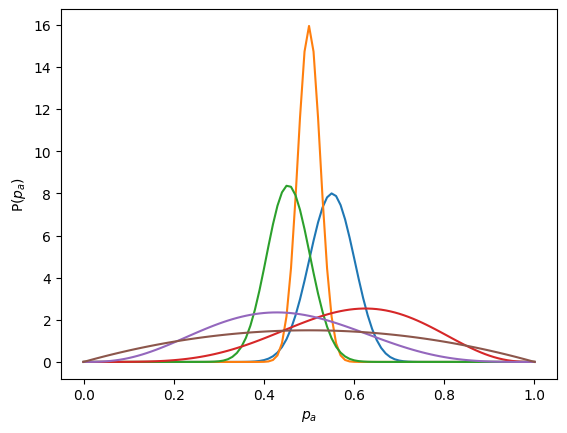

In [3]:
fig, ax = plt.subplots()

x = np.linspace(0,1,101)

for a, b in params:
    plt.plot(x, scipy.stats.beta.pdf(x, a, b))

plt.xlabel(r'$p_a$')
plt.ylabel(r'$\mathsf{P}(p_a)$')
plt.show()

In [4]:
# Number of Monte Carlo samples to validate estimates with
N = 100_000_000

seed = 42

values = np.vstack([
    scipy.stats.beta.rvs(alpha, beta, size=N, random_state=seed+i)
    for i, (alpha, beta) in tqdm(enumerate(params), total=len(params))
])

values_reverse = np.vstack([
    scipy.stats.beta.rvs(alpha, beta, size=N, random_state=seed+i)
    for i, (alpha, beta) in tqdm(enumerate(params_reverse), total=len(params_reverse))
])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
# Could be made faster by storing log-beta values in a look-up table, avoiding double computations

def P_i_is_minimal(i, params):
    # Parameters without i
    A_without_i = [a for a in range(len(params)) if a != i]

    alphas = params[:,0]
    betas = params[:,1]
    
    # Create ranges for each j_a in A_without_i
    ranges = [np.arange(alphas[a]) for a in A_without_i]
    
    # Create a meshgrid of all combinations of j_a
    grids = np.meshgrid(*ranges, indexing='ij')
    
    # Stack the grids into a single array of shape (num_combinations, len(A_without_i))
    combinations = np.vstack([g.ravel() for g in grids])
    
    # Placeholder for result (in log-space)
    result_ln = betaln(alphas[i] + np.sum(combinations, axis=0), np.sum(betas)) - betaln(alphas[i], betas[i]) 

    # Iterate over each action a in A_without_i
    for j, a in enumerate(A_without_i):
        # For each action a, we need to add the log(beta_a + j_a) and log(B(1+j_a, beta_a))
        result_ln -= np.log(betas[a] + combinations[j])  # log(beta_a + j_a)
        result_ln -= betaln(1 + combinations[j], betas[a])  # log(B(1+j_a, beta_a))
        
    # Compute the total probability by summing over all combinations
    return np.sum(np.exp(result_ln))


def P_i_is_maximal(i, params):
    # Parameters without i
    A_without_i = [a for a in range(len(params)) if a != i]
    
    result = 1.0
    
    for size in range(1, len(A_without_i)+1):
        sign = (-1)**size
        for subset in itertools.combinations(A_without_i, size):
            result += sign * P_i_is_minimal(0, params[[i]+list(subset)])
    return result


In [6]:
def MC_i_is_minimal(i, values):
    return np.mean(np.argmin(values, axis=0) == i)

def MC_i_is_maximal(i, values):
    return np.mean(np.argmax(values, axis=0) == i)

In [7]:
%%time
print('P(i = argmin)')
print('Exact\tMonte-Carlo')
for i in tqdm(range(len(params)), total=len(params)):
    print(f'{P_i_is_minimal(i, params):.4f}\t{MC_i_is_minimal(i, values):.4f}')

P(i = argmin)
Exact	Monte-Carlo


  0%|          | 0/6 [00:00<?, ?it/s]

0.0106	0.0107
0.0297	0.0297
0.2013	0.2013
0.0749	0.0749
0.3644	0.3643
0.3191	0.3191
CPU times: user 14.3 s, sys: 12 s, total: 26.3 s
Wall time: 34.6 s


In [ ]:
%%time
print('P(i = argmax) when swapping alpha/beta')
print('Exact\tMonte-Carlo')
for i in tqdm(range(len(params_reverse)), total=len(params_reverse)):
    print(f'{P_i_is_maximal(i, params_reverse):.4f}\t{MC_i_is_maximal(i, values_reverse):.4f}')

P(i = argmax) when swapping alpha/beta
Exact	Monte-Carlo


  0%|          | 0/6 [00:00<?, ?it/s]

0.0106	0.0107
0.0297	0.0297
0.2013	0.2013
0.0749	0.0749


In [ ]:
%%time
print('P(i = argmax)')
print('Exact\tMonte-Carlo')
for i in tqdm(range(len(params)), total=len(params)):
    print(f'{P_i_is_maximal(i, params):.4f}\t{MC_i_is_maximal(i, values):.4f}')

In [ ]:
%%time
print('P(i = argmin) when swapping alpha/beta')
print('Exact\tMonte-Carlo')
for i in tqdm(range(len(params_reverse)), total=len(params_reverse)):
    print(f'{P_i_is_minimal(i, params_reverse):.4f}\t{MC_i_is_maximal(i, values):.4f}')   